In [4]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM
using SSMCMain.ModifiedMiCRM.RandomSystems
using SSMCMain.ModifiedMiCRM.GraphAnalysis

In [29]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions, StatsBase
using FreqTables

using GraphvizDotLang
using GraphvizDotLang: digraph, edge, node, attr, subgraph

using Graphs
using MetaGraphsNext

using GraphMakie
using GraphMakie.NetworkLayout

In [20]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [198]:
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end

sigma_to_mu_ratio1 (generic function with 1 method)

In [23]:
function threshold_func1(data)
    xx = sort(data)
    m = mean(xx)
    xx[findfirst(x -> x > m, xx)] - 100*eps()
end

threshold_func1 (generic function with 1 method)

In [130]:
Ns = 10
Nr = 10

total_influx = 1. * Ns
sparsity_influx = 0.3
Kmean = total_influx / (sparsity_influx * Nr)
K = (Kmean, Kmean * sigma_to_mu_ratio1())

rsg = RSGJans1(Ns, Nr;
    r=1.,
    m=0.2 .* (1., sigma_to_mu_ratio1()),
    
    sparsity_influx, K,
    
    c=1. .* (1., sigma_to_mu_ratio1()),
    l=0.9 .* (1., sigma_to_mu_ratio1()),
    
    sparsity_resources=0.5,
    sparsity_byproducts=0.2,
    # num_used_resources=4,
    # num_byproducts=4,
    
    Ds=1e-8, Dr=1.,
)

@time rslts, params, params_sss = example_do_rg_run2(rsg, 100, 100., 1000;
    extinctthr=1e-12,
    return_int=c->c in [1, 2],
    return_int_sss=true,
    maxresidthr=1e-9,
    ode_solver=TRBDF2(),
    tol=1e-12,
    timelimit=5,
    maxiters=1000000,
    isoutofdomain=(u,_,_)->minimum(u) < 0.
)
countmap(rslts)

┌ Warning: At t=190.49039744484574, dt was forced below floating point epsilon 2.842170943040401e-14, and step error estimate = 6.4458468384839e-36. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Warning: At t=362.97243575816657, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 5.548065919858343e-36. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:174
┌ Warnin

 53.282531 seconds (33.11 M allocations: 7.016 GiB, 4.83% gc time, 53.15% compilation time)


Dict{Int64, Int64} with 4 entries:
  -1015 => 33
  -1007 => 5
  2     => 6
  1     => 56

In [135]:
xx = map(minimum, params_sss)
@show minimum(xx);
# sort(xx)

minimum(xx) = 9.081671207871599e-228


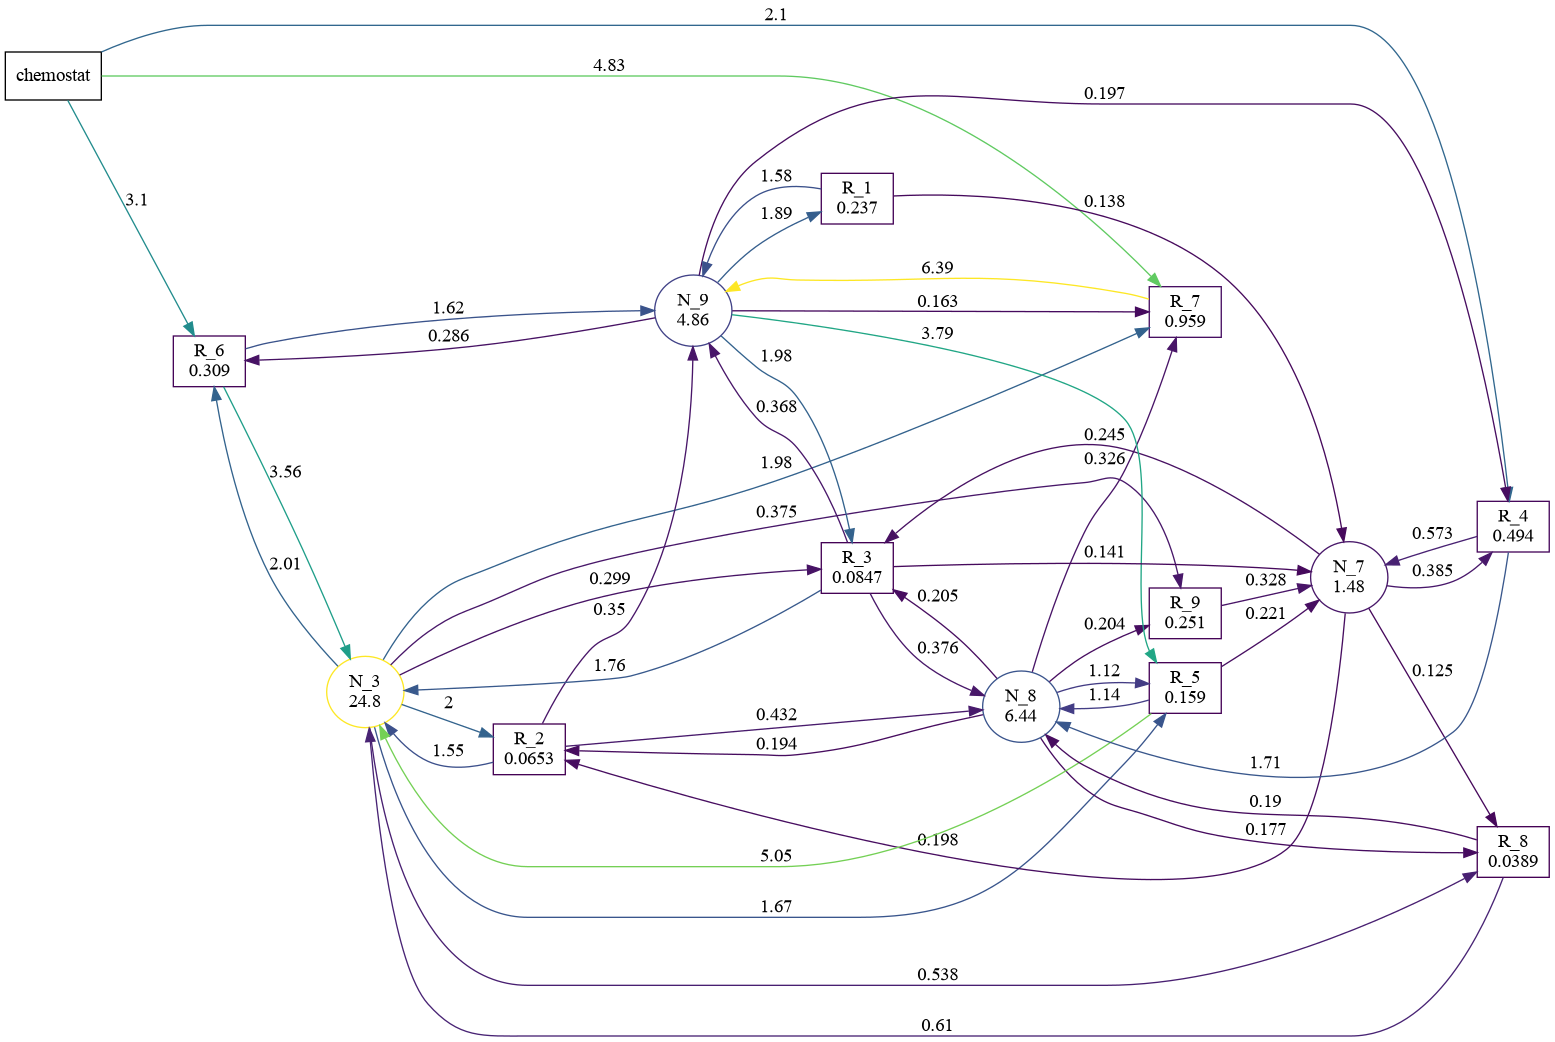

In [265]:
i = 1
ps = params[i]
ss = params_sss[i]
# ss = clamp_ss(ss)

g = diagram_sfss_v3(ps, ss;
    # strain_threshold=threshold_func1(ss[1:Ns]),
    strain_threshold=1.,
    # strain_threshold=-Inf,
    # edge_threshold=1e-10,
    # edge_threshold=-Inf,
    edge_threshold=0.1,
    colorscale=identity,
    # cluster=true,
)
# GraphvizDotLang.save(g, "kak.pdf"; format="pdf")

# Energy flow graph (simple version)

In [199]:
mg = make_eflowgraph_simple(ps, ss)
mgne = remove_env(mg);
nv(mg), ne(mg)

(22, 143)

### Base plotting

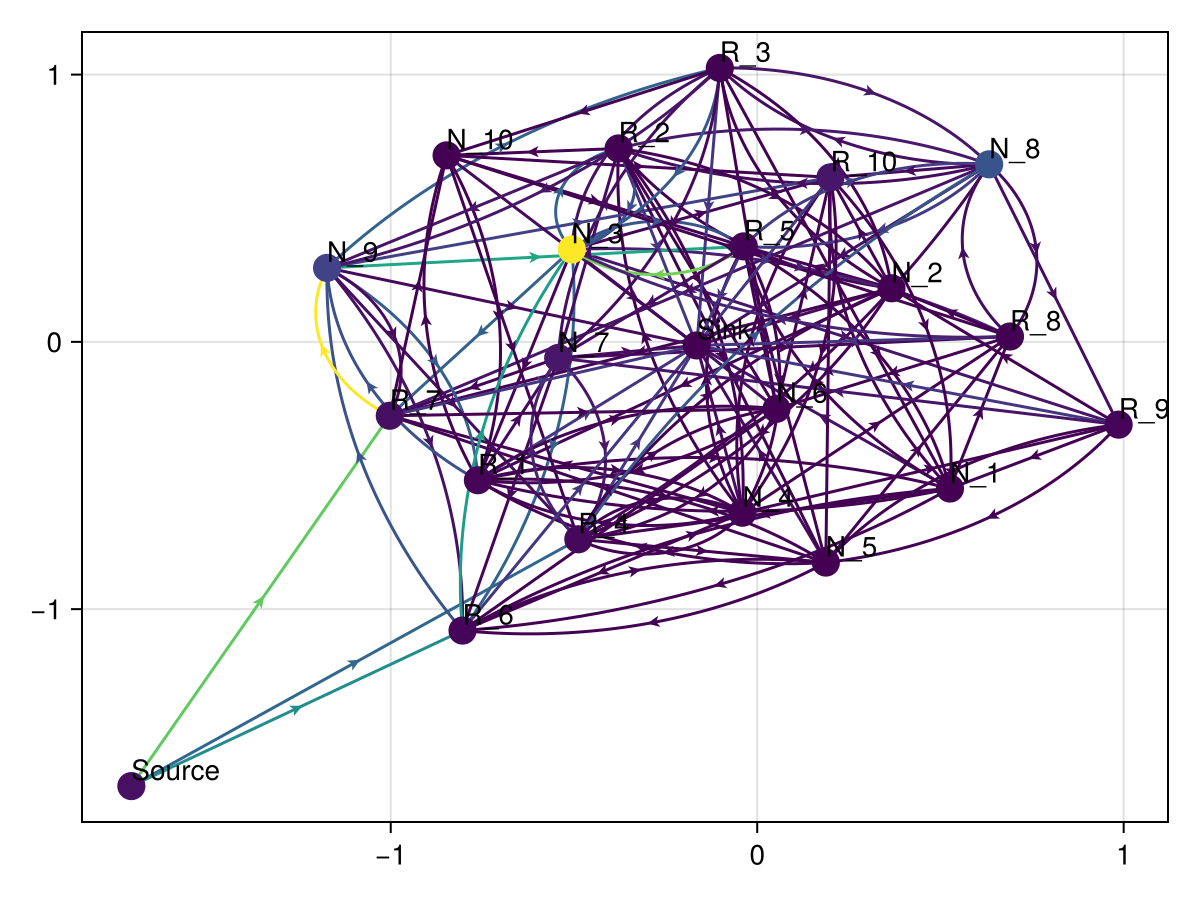

In [200]:
mgtp = mg
# mgtp = remove_env(mg)

# layout=stress(mgtp; weights=Graphs.weights(mgtp), dim=2)
layout=spring(mgtp; dim=2)
# layout=spectral(mgtp; dim=2)
# layout=spectral(mgtp; nodeweights=[mgtp[l].val for l in labels(mgtp)], dim=2)
# layout=spectral(mgtp)

fap = graphplot(mgtp;
    nlabels=[mgtp[l].name for l in labels(mgtp)],
    node_color=[mgtp[l].val for l in labels(mgtp)],
    # node_color=[ColorSchemes.tab10[i] for i in pp.assignments],
    node_size=20,
    edge_color=[mgtp[s,d] for (s, d) in edge_labels(mgtp)],
    layout
)
# display(GLMakie.Screen(), fap.figure)
fap

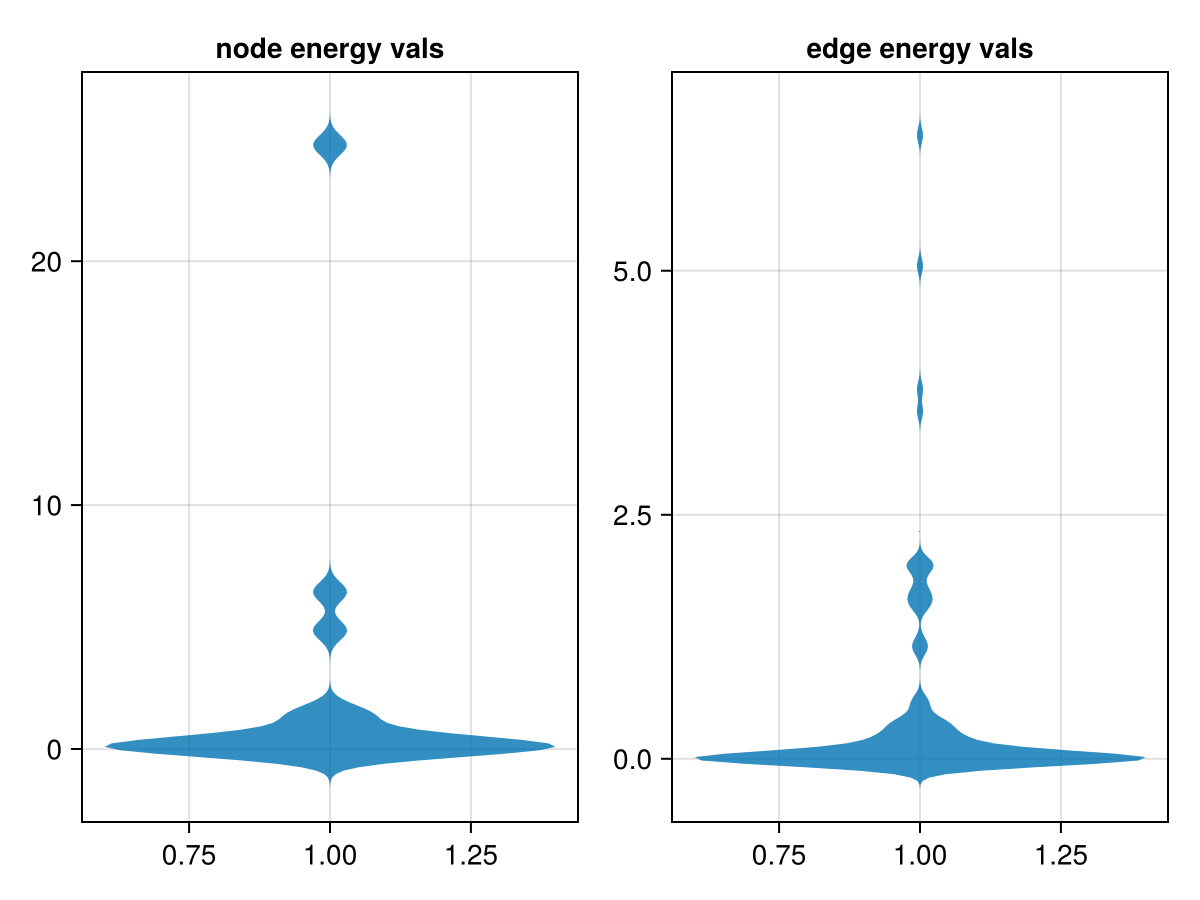

In [171]:
xx1 = [mgne[l].val for l in labels(mgne)]
fap = violin(fill(1, length(xx1)), xx1)
fap.axis.title = "node energy vals"

xx2 = [mgne[s,d] for (s, d) in edge_labels(mgne)]
sort(xx2)
ax2 = Axis(fap.figure[1,2])
violin!(ax2, fill(1, length(xx2)), xx2)
ax2.title = "edge energy vals"

fap

### Testing

### Paths

In [897]:
L = 3
xx = all_simple_paths(mg, 8, 1:nv(mg); cutoff=L)
i = 1
for p in xx
    if i == 10000000
        break
    end
    i += 1
    if length(p) == L
        @show p
        if p[begin] == p[end]
        end
    end
end
@show i

p = [8, 14, 2]
p = [8, 14, 4]
p = [8, 15, 2]
p = [8, 15, 3]
p = [8, 15, 5]
p = [8, 15, 6]
p = [8, 15, 9]
p = [8, 15, 11]
p = [8, 15, 12]
p = [8, 16, 2]
p = [8, 16, 3]
p = [8, 16, 4]
p = [8, 16, 6]
p = [8, 16, 7]
p = [8, 16, 9]
p = [8, 16, 11]
p = [8, 17, 2]
p = [8, 17, 4]
p = [8, 17, 5]
p = [8, 17, 6]
p = [8, 17, 7]
p = [8, 17, 11]
p = [8, 17, 12]
p = [8, 18, 2]
p = [8, 18, 3]
p = [8, 18, 6]
p = [8, 18, 7]
p = [8, 18, 9]
p = [8, 18, 10]
p = [8, 19, 2]
p = [8, 19, 3]
p = [8, 19, 9]
p = [8, 19, 10]
p = [8, 19, 11]
p = [8, 20, 2]
p = [8, 20, 4]
p = [8, 20, 5]
p = [8, 20, 10]
p = [8, 22, 2]
p = [8, 22, 4]
p = [8, 22, 5]
p = [8, 22, 7]
p = [8, 22, 9]
p = [8, 22, 10]
p = [8, 22, 11]
p = [8, 22, 12]
i = 325


325

### Clustering coeffs

Note that these will probably suck due to the different kinds of nodes as these clustering metrics are based on numbers of closed and open triangles however we won't have closed triangles as we only have arrows between strains and resources meaning a closed loop can only happen with even numbers of nodes.

In [764]:
global_clustering_coefficient(mg)

0.0343108504398827

In [768]:
label_for(mg, 3)

S(1)

In [767]:
xx1 = local_clustering.(Ref(mg), 1:nv(mg))
xx2 = local_clustering_coefficient.(Ref(mg), 1:nv(mg))
[(a[1], a[2], b) for (a, b) in zip(xx1, xx2)]

22-element Vector{Tuple{Int64, Int64, Float64}}:
 (0, 0, 0.0)
 (0, 380, 0.0)
 (7, 156, 0.04487179487179487)
 (8, 182, 0.04395604395604396)
 (5, 110, 0.045454545454545456)
 (6, 132, 0.045454545454545456)
 (6, 132, 0.045454545454545456)
 (8, 182, 0.04395604395604396)
 (7, 156, 0.04487179487179487)
 (6, 132, 0.045454545454545456)
 (7, 156, 0.04487179487179487)
 (7, 156, 0.04487179487179487)
 (4, 110, 0.03636363636363636)
 (2, 110, 0.01818181818181818)
 (6, 156, 0.038461538461538464)
 (6, 182, 0.03296703296703297)
 (6, 210, 0.02857142857142857)
 (5, 132, 0.03787878787878788)
 (5, 132, 0.03787878787878788)
 (4, 132, 0.030303030303030304)
 (4, 132, 0.030303030303030304)
 (8, 240, 0.03333333333333333)

### Rest

In [659]:
xx = collect(Graphs.weights(mg));
extrema(xx)

(-3.579110212079973e-18, 10000.0)

In [729]:
pp = mcl(xx; inflation=10)
@show pp.counts
pp.assignments

pp.counts = [15, 6]


21-element Vector{Int64}:
 1
 2
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 2
 1
 2
 2
 2
 1
 2
 1

In [702]:
pp.counts

2-element Vector{Int64}:
 15
  6

# Reduced strain only graph

In [195]:
mg = make_eflowgraph_simple(ps, ss)
nv(mg), ne(mg)

(22, 143)

In [260]:
sg = make_strain_ecouple_graph(mg;
    default_weight=1e6,
    skip_self=true,
    threshold=eps()
);
nv(sg), ne(sg)

(10, 43)

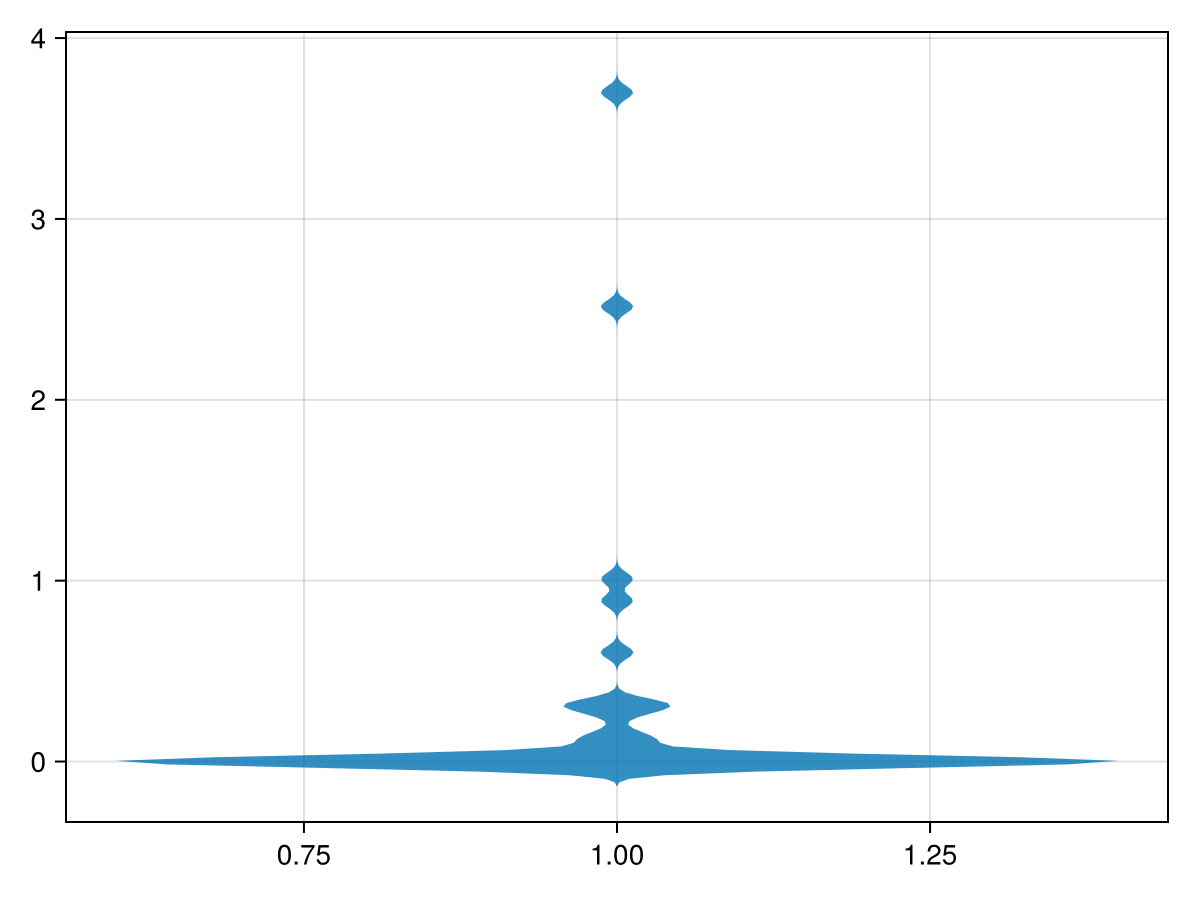

In [262]:
xx = [sg[s,d] for (s,d) in edge_labels(sg)]
sort(xx)
violin(fill(1, length(xx)), xx)

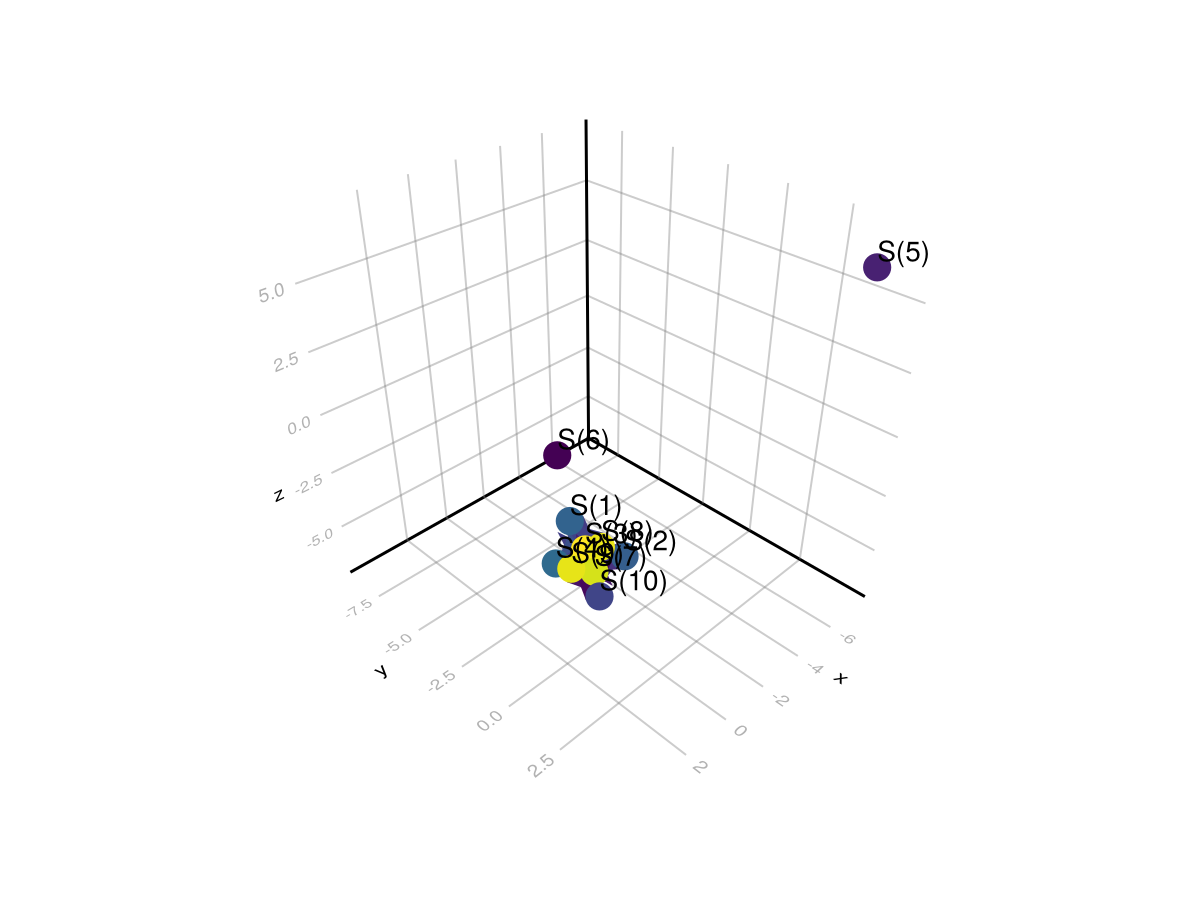

In [263]:
# layout=stress(sg; weights=Graphs.weights(sg), dim=3)
layout=spring(sg; dim=3)
# layout=stress(sg)
# layout=spring(sg; dim=2)

edge_attr = (; colorscale=log10)
fap = graphplot(sg;
    nlabels=string.(labels(sg)),
    node_color=[sg[l] for l in labels(sg)],
    node_attr=(; colorscale=log10),
    node_size=20,
    edge_color=[sg[s,d] for (s, d) in edge_labels(sg)],
    arrow_size=20,
    edge_attr, arrow_attr=edge_attr,
    layout
)
display(GLMakie.Screen(), fap.figure)
fap

# Running a single system

In [56]:
ps = rsg();

In [149]:
ps = params[2];

## No space solver

In [1010]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=nothing,
);
maximum(abs, sss.resid)

  8.940226 seconds (14.43 M allocations: 875.768 MiB, 4.41% gc time, 96.79% compilation time)


6.59705744443179e-15

  0.001442 seconds (695 allocations: 133.234 KiB)


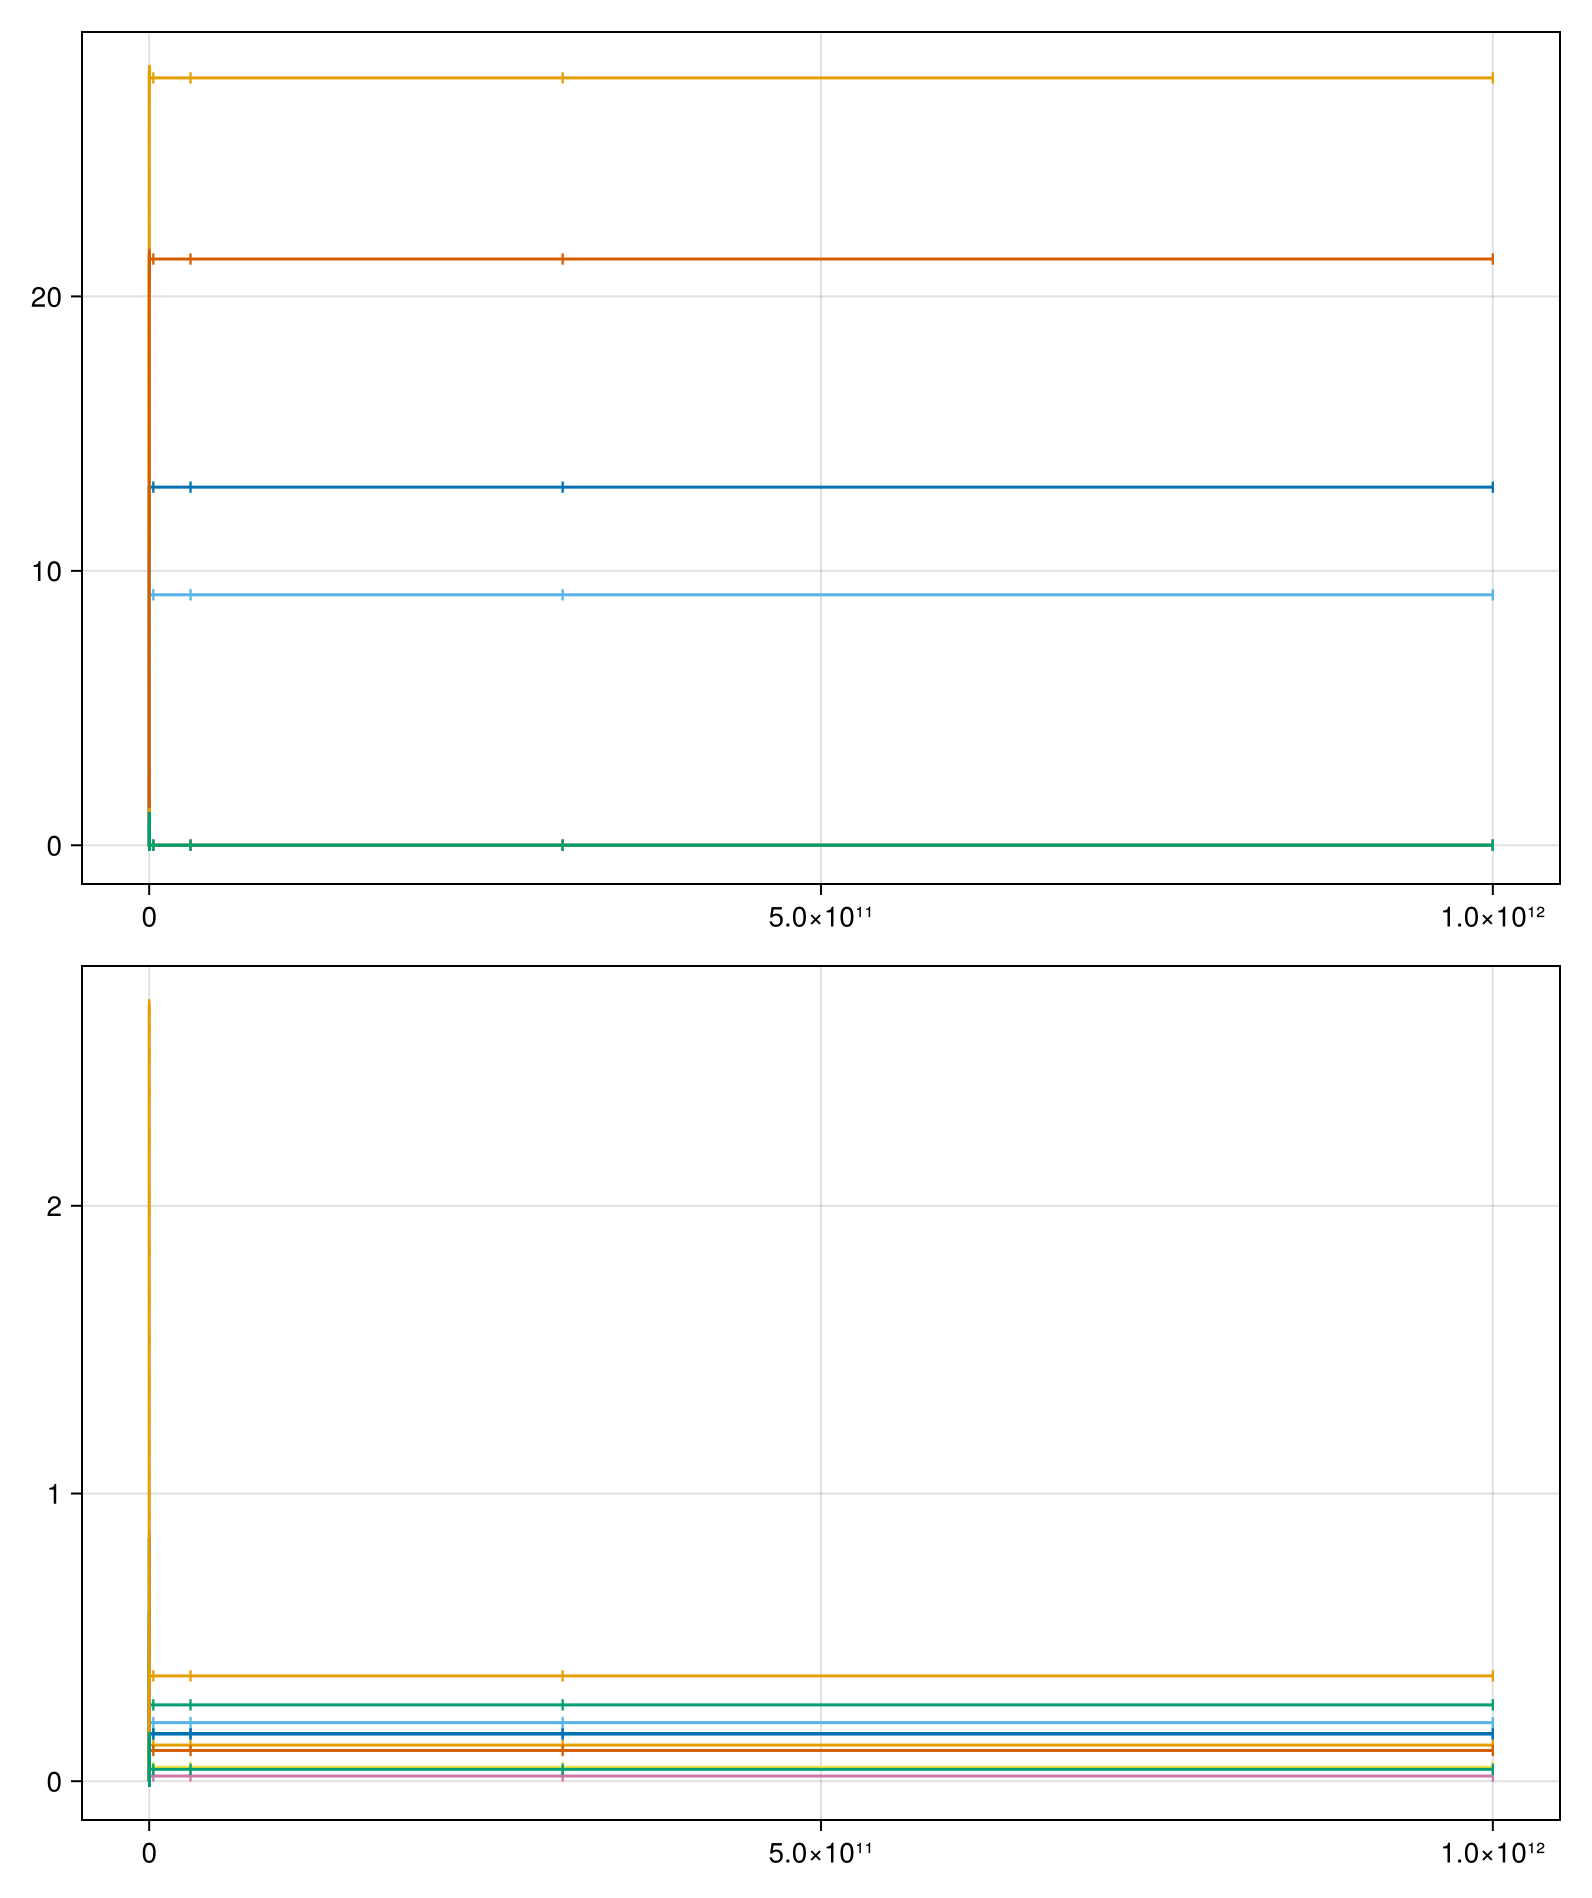

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict

In [1018]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000000000);
# p = remake_guarantee_positive(p)

@time s = solve(p, QNDF();
    callback=make_timer_callback(0.5)
)

f = plot_mmicrm_sol(s)
display(GLMakie.Screen(), f)
f

## Spatial stuff

In [168]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 1.1988757040423928e-14


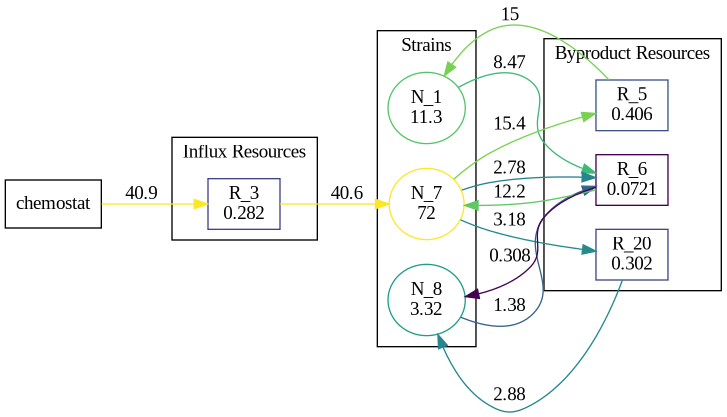

In [176]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10,
    edge_threshold=1e-20,
    cluster=true,
)

### Linear stability

In [196]:
ks = LinRange(0., 1000., 10000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

Ns = get_Ns(ps)[1]
Ds[Ns+5] = 1e-3
Ds[Ns+6] = 1e-3
Ds[Ns+20] = 1e-3

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0010819294251180958

[ Info: Unstable, mrl is 0.00108193


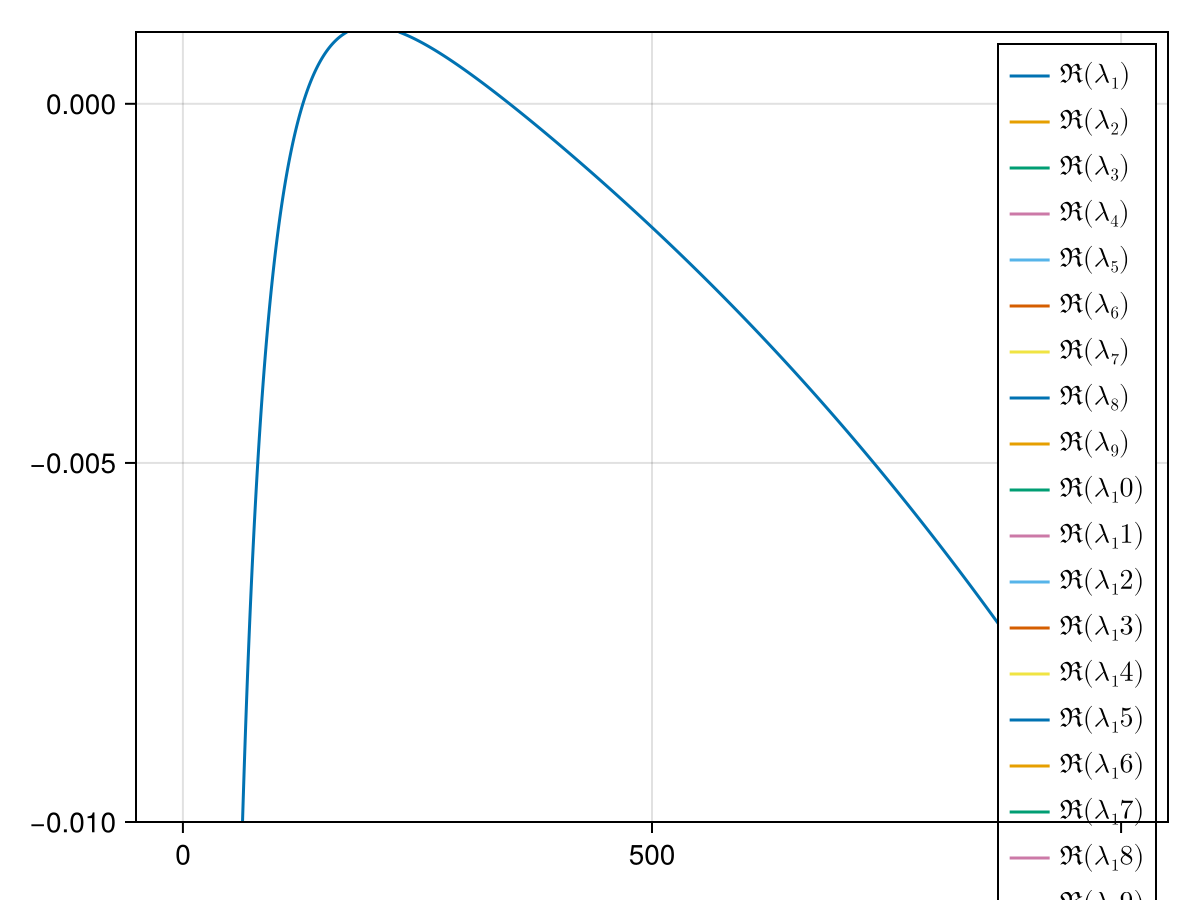

In [197]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


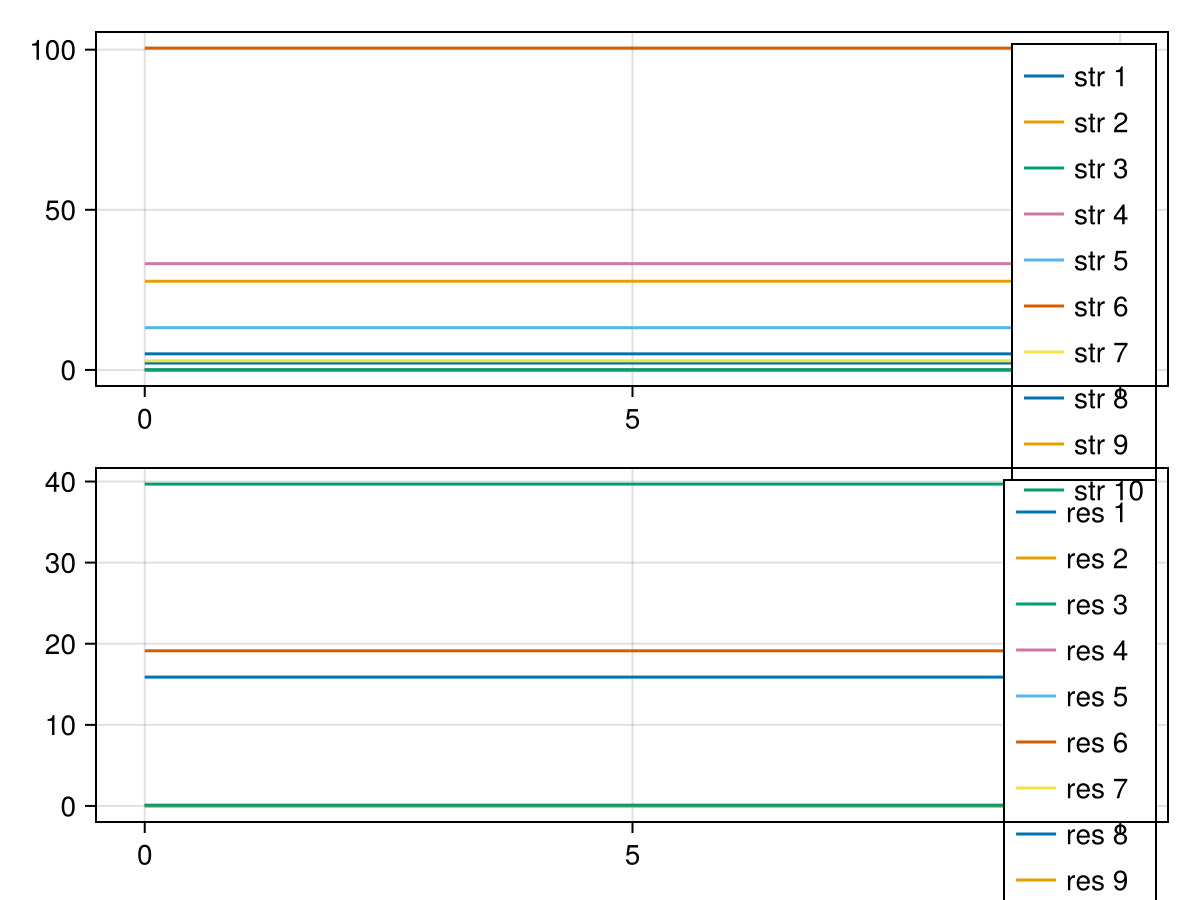

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

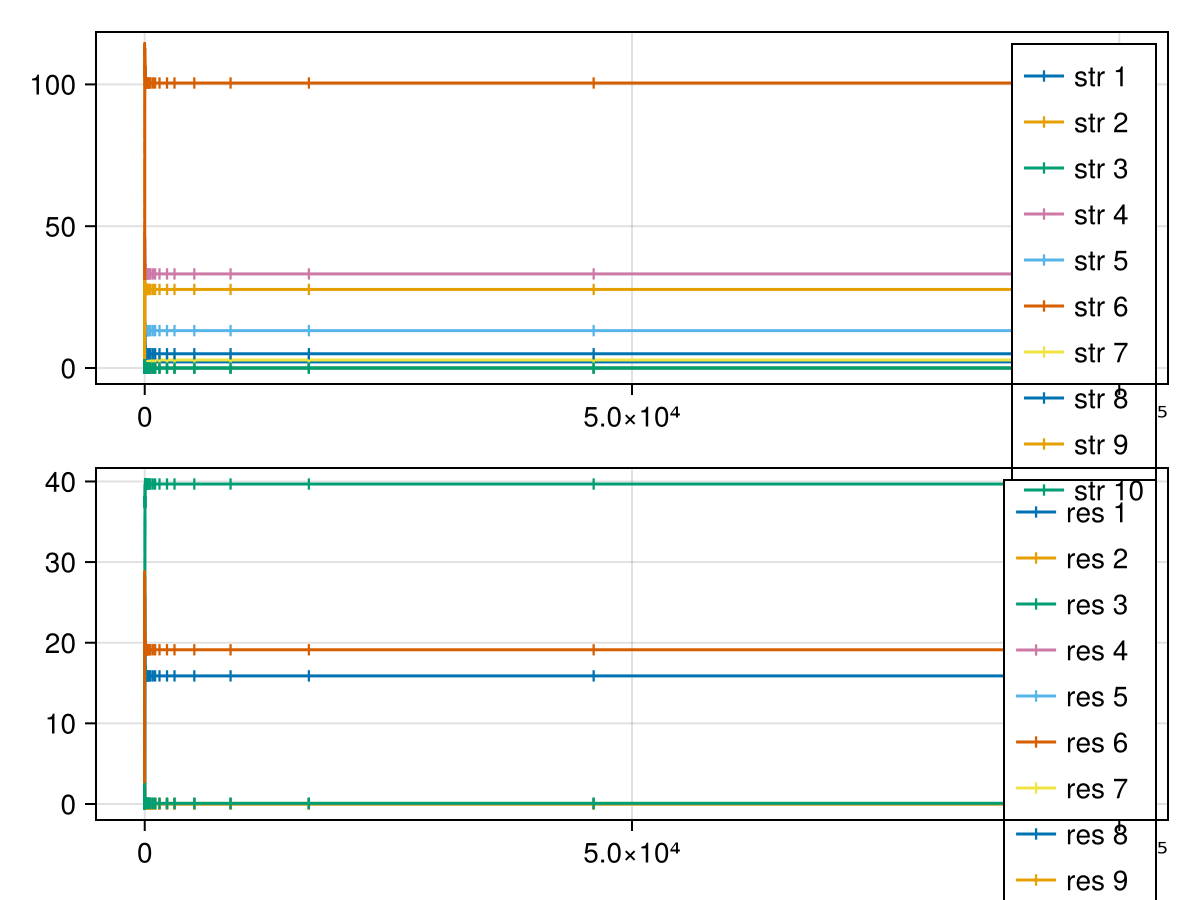

In [353]:
plot_smmicrm_sol_avgs(sps)

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()